# KNN

## Necessary libraries

In [2]:
%pip install scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.decomposition import PCA

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Load the data and define variables

In [3]:
# Taining and testing data
train = pd.read_csv('data/sign_mnist_train.csv')
test = pd.read_csv('data/sign_mnist_test.csv')

# Size of the images
image_width = 28
image_height = 28

## Load and split training data and training evaluation data

In [4]:
# training images
X = np.array(train.drop('label', axis=1))
# training labels
y = np.array(train['label'])

# number of examples
m = len(y)

# normalize the data
# Pixel values typically range from 0 to 255.
# Dividing by 255.0 scales the data to a [0, 1] range.
# Normalization improves the performance and convergence speed of many machine learning algorithms

pixel_max_value = 255.0

X = np.array(X , dtype='float')/ pixel_max_value

# number of different labels
n_classes = len(np.unique(y))

# we get 24 instead of 26 labels because we do not have "j" and "z" samples (maybe because they are movement signals).
# in order to not get empty labels lets rename the labels
for i in range(len(y)):
    if y[i] > 8:
        y[i] -= 1

#split data into train and evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Number of features: {X.shape[1]}')
print(f'Number of classes: {n_classes}')
print("Number of training examples: ", len(y_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("Number of validation examples: ", len(y_val))
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)


Number of features: 784
Number of classes: 24
Number of training examples:  21964
X_train shape:  (21964, 784)
y_train shape:  (21964,)
Number of validation examples:  5491
X_val shape:  (5491, 784)
y_val shape:  (5491,)


## Model Test Data

In [5]:
X_test = np.array(test.drop('label', axis=1))
y_test = np.array(test['label'])

# number of test examples
m_test = len(y_test)

pixel_max_value = 255.0

X_test = np.array(X_test , dtype='float')/ pixel_max_value

n_test_classes = len(np.unique(y_test))

for i in range(len(y_test)):
    if y_test[i] > 8:
        y_test[i] -= 1


print(f'Number of test examples: {m_test}')
print(f'X_test_shape: {X_test.shape}')
print(f'y_test_shape: {y_test.shape}')

Number of test examples: 7172
X_test_shape: (7172, 784)
y_test_shape: (7172,)


## Test Model


Best PCA Variance: 0.95, Best k: 1, Accuracy: 0.9991
Number of PCA components retained: 113

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       331
           1       0.96      0.93      0.94       432
           2       0.98      1.00      0.99       310
           3       0.82      0.93      0.87       245
           4       0.78      0.98      0.87       498
           5       0.92      0.91      0.92       247
           6       0.90      0.94      0.92       348
           7       0.99      0.94      0.96       436
           8       0.90      0.72      0.80       288
           9       0.84      0.61      0.71       331
          10       0.92      0.92      0.92       209
          11       0.84      0.54      0.66       394
          12       0.82      0.67      0.74       291
          13       1.00      0.94      0.97       246
          14       1.00      1.00      1.00       347
   

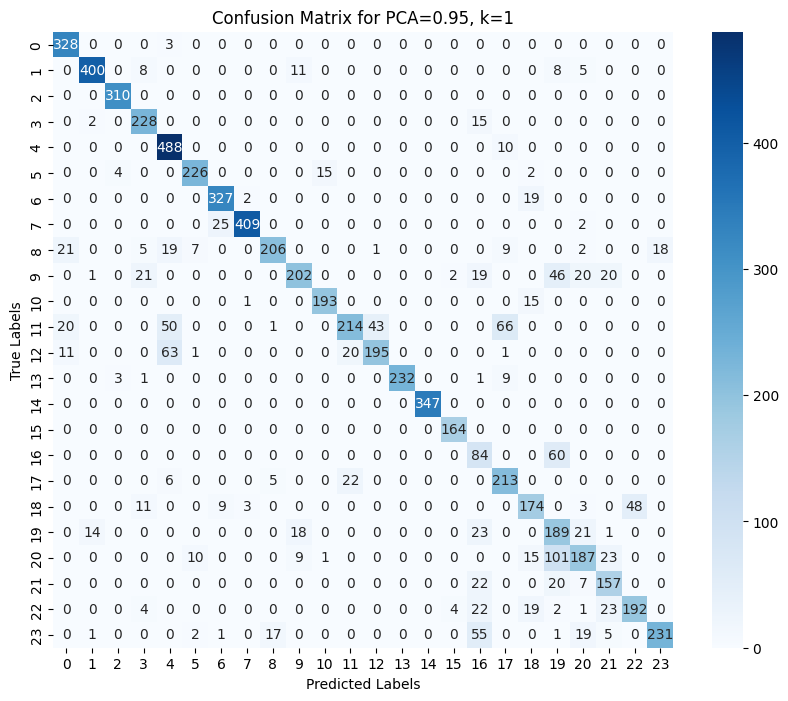

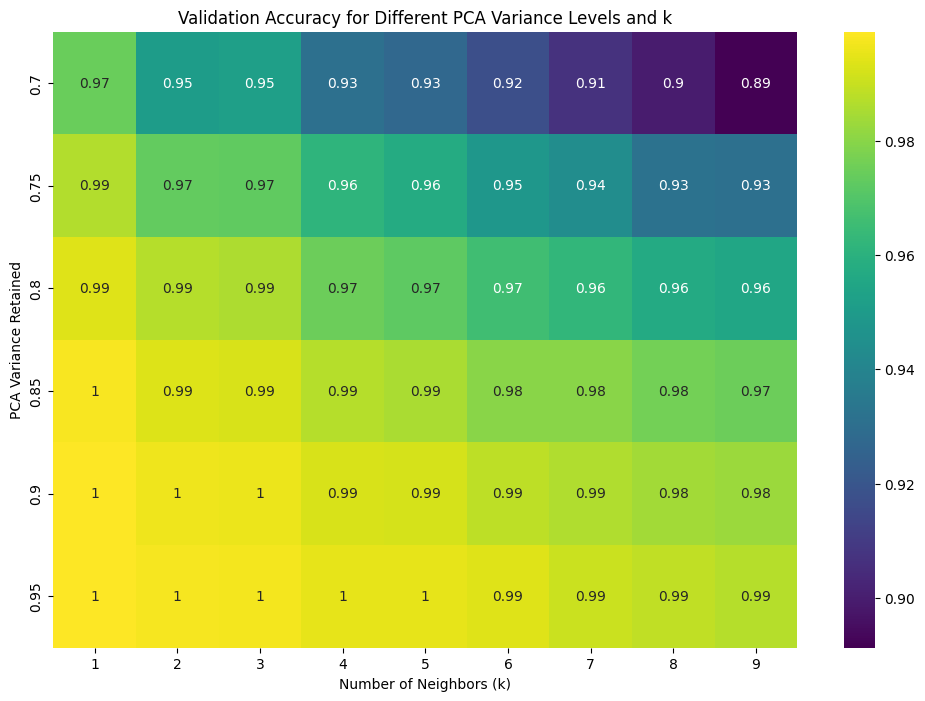

In [6]:
# Define ranges
k_values = list(range(1, 10))
pca_values = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Initialize storage
accuracy_matrix = np.zeros((len(pca_values), len(k_values)))

# Grid search over PCA variances and k values
for i, pca_var in enumerate(pca_values):
    pca = PCA(n_components=pca_var)
    pca.fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    for j, k in enumerate(k_values):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_val_pca)
        acc = accuracy_score(y_val, y_pred)
        accuracy_matrix[i, j] = acc

# Find best PCA and k
best_index = np.unravel_index(np.argmax(accuracy_matrix), accuracy_matrix.shape)
best_pca = pca_values[best_index[0]]
best_k = k_values[best_index[1]]
best_accuracy = accuracy_matrix[best_index]

print(f"\nBest PCA Variance: {best_pca}, Best k: {best_k}, Accuracy: {best_accuracy:.4f}")

# Retrain on best configuration
pca = PCA(n_components=best_pca)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train_pca, y_train)
best_y_pred = best_model.predict(X_test_pca)

print(f"Number of PCA components retained: {pca.n_components_}")

# Classification Report
print("\nClassification Report for Best Model:")
print(classification_report(y_test, best_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for PCA={best_pca}, k={best_k}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Heatmap of Accuracy for PCA vs k
plt.figure(figsize=(12, 8))
sns.heatmap(accuracy_matrix, annot=True, xticklabels=k_values, yticklabels=pca_values, cmap='viridis')
plt.title("Validation Accuracy for Different PCA Variance Levels and k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("PCA Variance Retained")
plt.show()

> My results conclude that K=1 is the number of neighboors which allows the algorithm to have better accuracy.

- KNN with k=1 simply predicts the class of the closest training sample.
- It perfectly memorizes the training data — no averaging, no generalization.

It may indicate overfitting, but accuracy doesn't drop much for higher number of k.

> PCA Usage

This reduced the number of features of the dataset to combat overfitting and improve performance. Reducing the number of features from 784 to 113 mantains 95% of variance which is a good trade off in order to get better model performance.